In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

## Reading and preparing data

In [57]:
df = pd.read_csv("processed_data18.csv") 
df.head(n=5)  # visualize the data.

,Unnamed: 0,time,y,x1,x2,x3,x4,x5,x6,x7,...,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60,trend_x61
0,0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df=df.fillna(0)

In [59]:
# Remove time & categorical column
df = df.drop(['Unnamed: 0','x28','lag_1_x28','expanding_mean_x28','rolling_mean_x28','x28_pct_change_5','cnv_x28',
             'pool_x28','drift_x28','tw_x28','trend_x28','x61','expanding_mean_x61','rolling_mean_x61','x61_pct_change_5',
             'cnv_x61','drift_x61','tw_x61','trend_x61'], axis=1)

### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [60]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [61]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


If we note here, we moved the positive label at 5/1/99 8:38 to t-1 and t-2 timestamps, and dropped row t. There is a time difference of more than 2 minutes between a break row and the next row because in the data consecutive break rows are deleted. This was done to prevent a classification model learn predicting a break after the break has happened. Refer https://arxiv.org/abs/1809.10717 for details.

In [62]:
# Remove time column, and the categorical columns
df = df.drop(['time'], axis=1)

In [63]:
df

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,trend_x51,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60
0,0.0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0.0,-0.877441,0.786430,0.406426,135.301215,0.112295,26.300392,-0.159185,0.058823,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18394,0.0,-0.843988,0.633086,0.561918,133.228949,0.141332,25.678597,-0.159185,0.058823,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18395,0.0,-0.826547,0.450126,0.334582,134.977973,0.170370,25.056801,-0.159185,0.048752,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18396,0.0,-0.822843,0.419383,0.387263,135.658942,0.199422,24.435005,-0.159185,0.048752,-0.080108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18274 entries, 0 to 18397
Columns: 592 entries, y to trend_x60
dtypes: float64(592)
memory usage: 82.7 MB


# Prepare data for LSTM models

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [65]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [66]:
n_features

591

In [67]:
input_y

array([0., 0., 0., ..., 0., 0., 0.])

In [68]:
input_X

array([[ 0.37666549, -4.5964348 , -4.0957558 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47572049, -4.5425018 , -4.0183588 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36384849, -4.6813938 , -4.3531468 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.8265475 ,  0.45012618,  0.3345822 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.8228425 ,  0.41938318,  0.3872632 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.8409805 ,  0.58271018,  0.5934162 , ...,  0.        ,
         0.        ,  0.        ]])

In [69]:
n_features

591

In [70]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the `temporalize` function with `lookback=5`. For the modeling, we may use a longer lookback.

In [71]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,trend_x51,trend_x52,trend_x53,trend_x54,trend_x55,trend_x56,trend_x57,trend_x58,trend_x59,trend_x60
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,29.984624,10.059739,-3.959576,-5.049040,-56.762042,36.391216,4.341802,0.030712,3.663376,0.007524
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,...,29.984624,9.895886,-4.409839,-5.053885,-55.075211,35.566470,4.395473,0.030112,3.745795,0.007472
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,9.732371,-4.858123,-5.058698,-53.470226,34.681130,4.445356,0.029505,3.833389,0.007420
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,9.569201,-5.304429,-5.063479,-51.280735,33.894202,4.484294,0.028946,3.919869,0.007368
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,9.406376,-5.748756,-5.068229,-48.989707,33.152143,4.550909,0.028379,3.997342,0.007316
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,9.243888,-6.191106,-5.072946,-47.280866,31.096881,4.572061,0.027805,4.057599,0.007263


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,590
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,0.001791,...,29.984624,9.895886,-4.409839,-5.053885,-55.075211,35.566470,4.395473,0.030112,3.745795,0.007472
1,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,0.001791,...,29.984624,9.732371,-4.858123,-5.058698,-53.470226,34.681130,4.445356,0.029505,3.833389,0.007420
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,9.569201,-5.304429,-5.063479,-51.280735,33.894202,4.484294,0.028946,3.919869,0.007368
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,9.406376,-5.748756,-5.068229,-48.989707,33.152143,4.550909,0.028379,3.997342,0.007316
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,9.243888,-6.191106,-5.072946,-47.280866,31.096881,4.572061,0.027805,4.057599,0.007263


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

### Divide the data into train, valid, and test

In [72]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [73]:
X_train.shape

(11691, 5, 1, 591)

In [74]:
np.array(y)

array([0., 0., 0., ..., 0., 0., 0.])

In [75]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [76]:
X_train_y0.shape

(11536, 5, 1, 591)

In [77]:
X_valid_y0.shape

(2880, 5, 1, 591)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [78]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature. 

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

- `flatten`: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of `temporalize`, meaning `X = flatten(temporalize(X))`.
- `scale`: This function will scale a 3D array that we created as inputs to the LSTM.

In [79]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [80]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [81]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [82]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0.  0.
  0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0.  0.  0.
  0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.  0.  0. -0. -0.  0.  0. -0.
  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0. -0.
 -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.
  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
 -0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0.
  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0.  0.
 -0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0.
 -0. -0. -0. -0. -0.  0.  0.  0. -0.  

The test succeeded. Now we will _scale_ the validation and test sets.

In [83]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [126]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [127]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(64, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 64)             167936    
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 5, 32)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 5, 16)             3136      
                                                                 
 lstm_19 (LSTM)              (None, 5, 32)             6272      
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 591)           19503     
 tributed)                                            

As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).

In [128]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/200
181/181 - 4s - loss: 3.9708 - val_loss: 3.7657 - 4s/epoch - 22ms/step
Epoch 2/200
181/181 - 2s - loss: 3.8376 - val_loss: 3.6167 - 2s/epoch - 10ms/step
Epoch 3/200
181/181 - 2s - loss: 3.7254 - val_loss: 3.5249 - 2s/epoch - 9ms/step
Epoch 4/200
181/181 - 2s - loss: 3.6667 - val_loss: 3.4683 - 2s/epoch - 9ms/step
Epoch 5/200
181/181 - 2s - loss: 3.6172 - val_loss: 3.4267 - 2s/epoch - 9ms/step
Epoch 6/200
181/181 - 2s - loss: 3.5781 - val_loss: 3.3946 - 2s/epoch - 9ms/step
Epoch 7/200
181/181 - 2s - loss: 3.5449 - val_loss: 3.3672 - 2s/epoch - 9ms/step
Epoch 8/200
181/181 - 2s - loss: 3.5186 - val_loss: 3.3447 - 2s/epoch - 9ms/step
Epoch 9/200
181/181 - 2s - loss: 3.4995 - val_loss: 3.3264 - 2s/epoch - 10ms/step
Epoch 10/200
181/181 - 2s - loss: 3.4833 - val_loss: 3.3106 - 2s/epoch - 9ms/step
Epoch 11/200
181/181 - 2s - loss: 3.4705 - val_loss: 3.2944 - 2s/epoch - 9ms/step
Epoch 12/200
181/181 - 2s - loss: 3.4532 - val_loss: 3.2796 - 2s/epoch - 10ms/step
Epoch 13/200
181/181 

Epoch 101/200
181/181 - 2s - loss: 3.1590 - val_loss: 3.1527 - 2s/epoch - 9ms/step
Epoch 102/200
181/181 - 2s - loss: 3.1489 - val_loss: 3.1637 - 2s/epoch - 9ms/step
Epoch 103/200
181/181 - 2s - loss: 3.1162 - val_loss: 3.1534 - 2s/epoch - 9ms/step
Epoch 104/200
181/181 - 2s - loss: 3.1158 - val_loss: 3.1526 - 2s/epoch - 9ms/step
Epoch 105/200
181/181 - 2s - loss: 3.0956 - val_loss: 3.1533 - 2s/epoch - 10ms/step
Epoch 106/200
181/181 - 2s - loss: 3.0856 - val_loss: 3.1531 - 2s/epoch - 9ms/step
Epoch 107/200
181/181 - 2s - loss: 3.0804 - val_loss: 3.1566 - 2s/epoch - 9ms/step
Epoch 108/200
181/181 - 2s - loss: 3.0765 - val_loss: 3.1579 - 2s/epoch - 9ms/step
Epoch 109/200
181/181 - 2s - loss: 3.0908 - val_loss: 3.1561 - 2s/epoch - 9ms/step
Epoch 110/200
181/181 - 2s - loss: 3.0924 - val_loss: 3.1657 - 2s/epoch - 9ms/step
Epoch 111/200
181/181 - 2s - loss: 3.0831 - val_loss: 3.1570 - 2s/epoch - 9ms/step
Epoch 112/200
181/181 - 2s - loss: 3.0712 - val_loss: 3.1557 - 2s/epoch - 9ms/step
Epo

Epoch 200/200
181/181 - 2s - loss: 3.1837 - val_loss: 3.1736 - 2s/epoch - 10ms/step


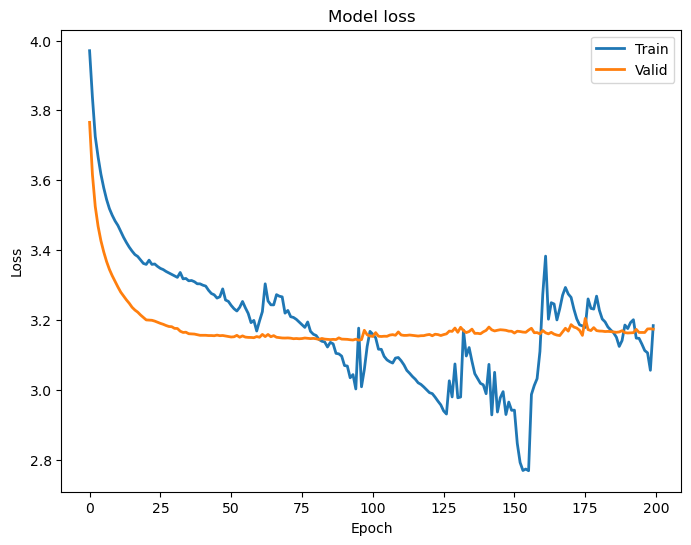

In [129]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check
Doing a sanity check by validating the reconstruction error 
on the train data. Here we will reconstruct the entire train 
data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should
be smaller than 1.

**Caution**: do not use this result for model evaluation. It may
result into overfitting issues.

366/366 [==============================] - 1s 2ms/step


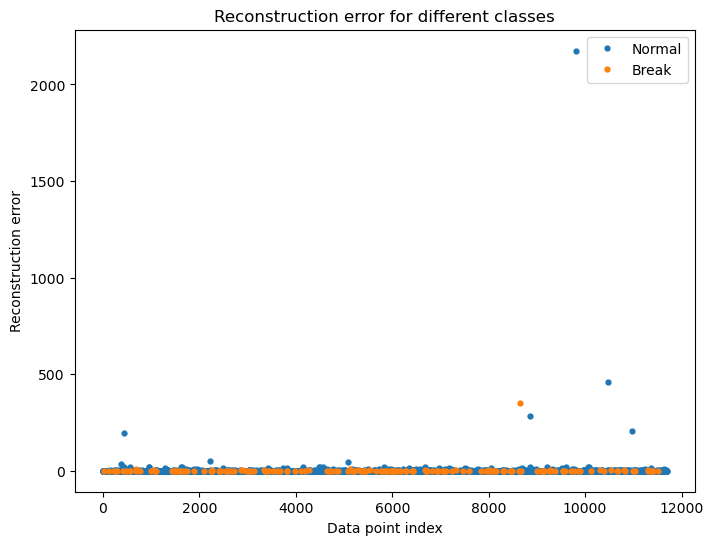

In [131]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the Autoencoder

92/92 [==============================] - 0s 2ms/step


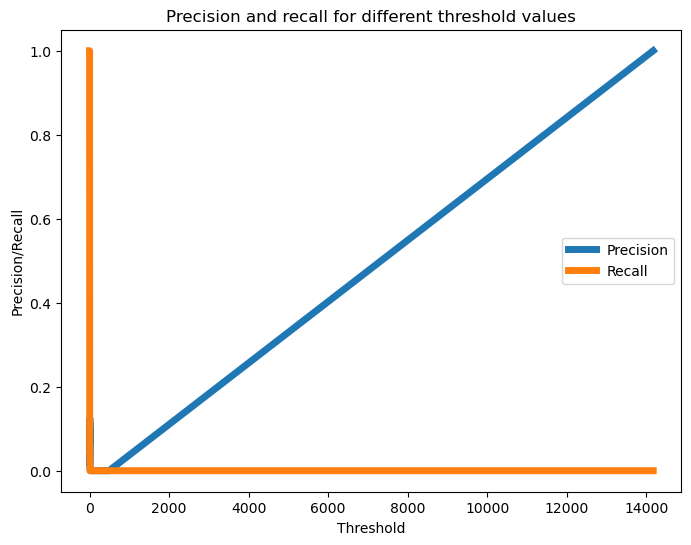

In [132]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

115/115 [==============================] - 0s 2ms/step


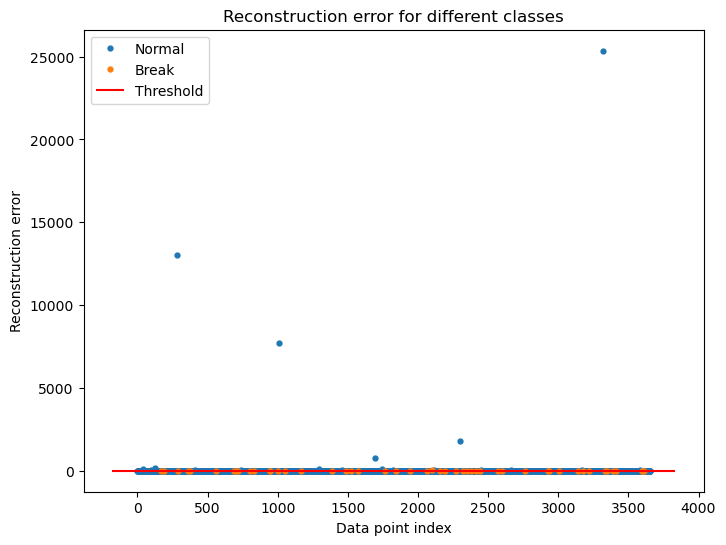

In [133]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [134]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

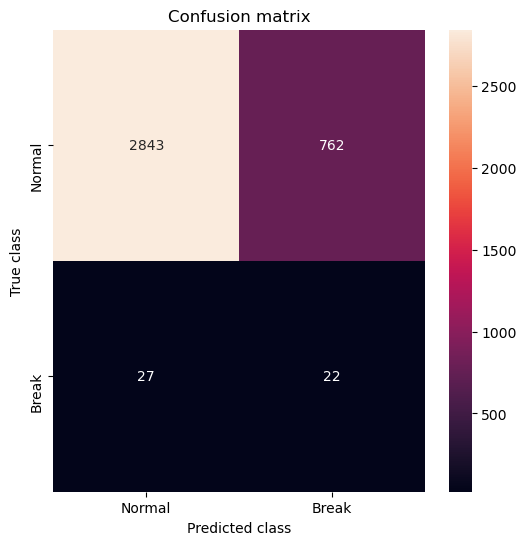

In [135]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [136]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      0.79      0.88      3605
       Break       0.03      0.45      0.05        49

    accuracy                           0.78      3654
   macro avg       0.51      0.62      0.47      3654
weighted avg       0.98      0.78      0.87      3654



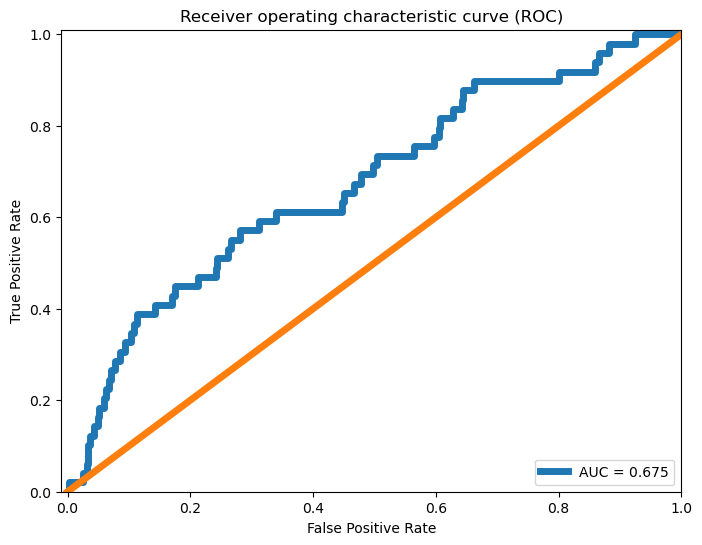

In [137]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()